# Task 3
Extract the following data from the graph generated in Task 2:
 1. Total length of the transport network
 2. The average distance between the stations
 3. The standard deviation of the distances between the stations


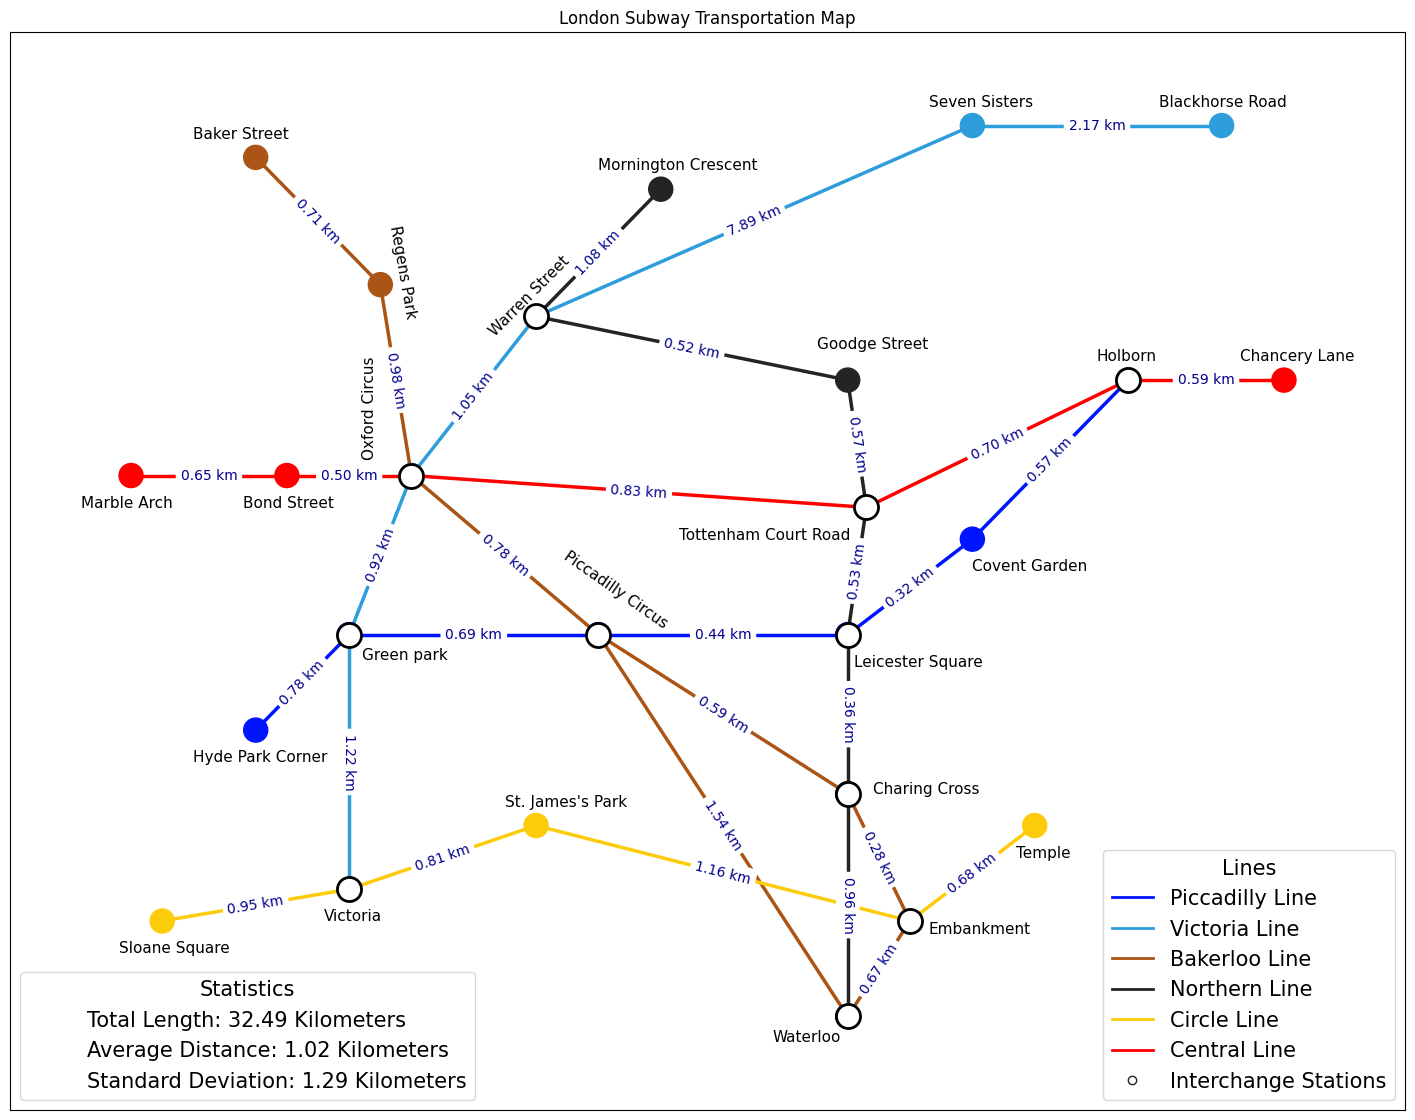

In [32]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd


def get_interchange_nodes(distance_df):
    interchange_node_dict = {}
    for index, row in distance_df.iterrows():
        if not row["StartStation"] in interchange_node_dict.keys():
            interchange_node_dict[row["StartStation"]] = 1
        else:
            interchange_node_dict[row["StartStation"]] += 1

        if not row["EndStation"] in interchange_node_dict.keys():
            interchange_node_dict[row["EndStation"]] = 1
        else:
            interchange_node_dict[row["EndStation"]] += 1

    interchange_nodes = []

    for key, val in interchange_node_dict.items():
        if interchange_node_dict[key] >= 3:
            interchange_nodes.append(key)

    return interchange_nodes


def draw_node_labels(edge_label_coords: list[dict], text_size: int = 11):
    for item in edge_label_coords:
        rotation = item.get("rotation", 0)
        plt.text(item["pos"]["x"], item["pos"]["y"], s=item["s"], size=text_size, rotation=rotation)


class MapGraph(nx.Graph):
    def add_node_to_graph(self, df):
        for index, row in df.iterrows():
            self.add_node(row["Station"], npos=(row["Latitude"], row["Longitude"]), ccn=row["Color"])
    
    def add_edge_to_graph(self, df):
        for index, row in df.iterrows():
            distance = row["Distance"]
            if row["Unit"] == "m":
                distance /= 1000
            self.add_edge(row["StartStation"], row["EndStation"], distance=f"{distance:.2f} km", cce=row["Color"], weight=round(distance,2), line=row["Line"])


col_names = ["Station", "Latitude", "Longitude", "Color"]
subway_df = pd.read_csv("subway_station_dataset.csv", usecols=col_names, na_values=["N/A", "Unknown"])
subway_df.dropna()
subway_df.drop_duplicates()

distance_df_colname = ["StartStation", "EndStation", "Distance", "Unit", "Color", "Line"]
distance_df = pd.read_csv("subway_station_distance.csv", usecols=distance_df_colname, na_values=["N/A", "Unknown"])
distance_df.dropna()
distance_df.drop_duplicates()

G = MapGraph()

G.add_node_to_graph(subway_df)
G.add_edge_to_graph(distance_df)

# Get positions from node attributes
pos = nx.get_node_attributes(G, 'npos')
node_colour = nx.get_node_attributes(G, 'ccn')
edge_colour = nx.get_edge_attributes(G, 'cce')

# Get line of Map
# lines = nx.get_edge_attributes(G, 'line')
# line_dict = {}
# for key, item in lines.items():
#     if not line_dict.get(item, None):
#         line_dict[item] = list(key)
#         continue
#     line_dict[item].extend(list(key))
#     line_dict[item] = list(set(line_dict[item]))

node_colours = list(node_colour.values())
edge_colours = list(edge_colour.values())

intersecting_nodes = get_interchange_nodes(distance_df=distance_df)

# Plotting
plt.figure(figsize=(18, 14))

# Draw Network
nx.draw_networkx(G, pos, node_color=node_colours, with_labels=False)

# Draw Nodes
nx.draw_networkx_nodes(G, pos, nodelist=intersecting_nodes, node_color='white', edgecolors='black', linewidths=2, node_size=300)

# Draw Edges
nx.draw_networkx_edges(G, pos, edge_color=edge_colours, width=2.5)

# Draw edge labels with distances
edge_labels = nx.get_edge_attributes(G, 'distance')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='darkblue')

text_size = 11
edge_label_coords = [
    # Piccadilly Label
    {"s": "Hyde Park Corner", "pos": {"x": 25, "y": 30}},
    {"s": "Green park", "pos": {"x": 52, "y": 46}},
    {"s": "Piccadilly Circus", "pos": {"x": 84, "y": 51}, "rotation": -35},
    {"s": "Leicester Square", "pos": {"x": 131, "y": 45}},
    {"s": "Covent Garden","pos": {"x": 150, "y": 60}},
    {"s": "Holborn", "pos": {"x": 170, "y": 93}},
    # Victoria Line Label
    {"s": "Victoria", "pos": {"x": 46, "y": 5}},
    {"s": "Oxford Circus", "pos": {"x": 52, "y": 78}, "rotation": 90},
    {"s": "Warren Street", "pos": {"x": 72, "y": 97}, "rotation": 45},
    {"s": "Seven Sisters", "pos": {"x": 143, "y": 133}},
    {"s": "Blackhorse Road", "pos": {"x": 180, "y": 133}},
    # Bakerloo Line Label
    {"s": "Embankment", "pos": {"x": 143, "y": 3}},
    {"s": "Charing Cross", "pos": {"x": 134, "y": 25}},
    {"s": "Regens Park", "pos": {"x": 56, "y": 100}, "rotation": 280},
    {"s": "Baker Street", "pos": {"x": 25, "y": 128}},
    # Northern Line Label
    {"s": "Waterloo", "pos": {"x": 118, "y": -14}},
    {"s": "Goodge Street", "pos": {"x": 125, "y": 95}},
    {"s": "Mornington Crescent", "pos": {"x": 90, "y": 123}},
    # Circle Line Label
    {"s": "St. James's Park", "pos": {"x": 75, "y": 23}},
    {"s": "Sloane Square", "pos": {"x": 13, "y": 0}},
    {"s": "Temple", "pos": {"x": 157, "y": 15}},
    # Central Line Label
    {"s": "Bond Street", "pos": {"x": 33, "y": 70}},
    {"s": "Marble Arch", "pos": {"x": 7, "y": 70}},
    {"s": "Tottenham Court Road", "pos": {"x": 103, "y": 65}},
    {"s": "Chancery Lane", "pos": {"x": 193, "y": 93}},
]

draw_node_labels(edge_label_coords, text_size=text_size)

total_length = round(G.size(weight="weight"), 2)
average_length = round(total_length / G.size(), 2)

weights = [d["weight"] for (u, v, d) in G.edges(data=True)]
std_distances = round(np.std(weights), 2)

# Add custom legend for the lines
line_labels = [
    Line2D([0], [0], color='#0015ff', lw=2, label='Piccadilly Line'),
    Line2D([0], [0], color='#2e9ddb', lw=2, label='Victoria Line'),
    Line2D([0], [0], color='#aa5516', lw=2, label='Bakerloo Line'),
    Line2D([0], [0], color='#262324', lw=2, label='Northern Line'),
    Line2D([0], [0], color='#fccc0a', lw=2, label='Circle Line'),
    Line2D([0], [0], color='#ff0000', lw=2, label='Central Line'),
    Line2D([0], [0], color='#262324', marker="o", lw=2, label='Interchange Stations', markerfacecolor="white", linestyle='None'),
]

line_labels_legend = plt.legend(handles=line_labels, loc='lower right', title="Lines", fontsize=15, title_fontsize=15)

# Add the first legend back to the plot
plt.gca().add_artist(line_labels_legend)

stats_labels = [
    Line2D([0], [0], color='white', label=f'Total Length: {total_length:.2f} Kilometers'),
    Line2D([0], [0], color='white', label=f'Average Distance: {average_length:.2f} Kilometers'),
    Line2D([0], [0], color='white', label=f'Standard Deviation: {std_distances:.2f} Kilometers'),
]
stats_legend = plt.legend(handles=stats_labels, loc='lower left', title="Statistics", fontsize=15, title_fontsize=15)

# Display the title and remove axes
plt.title("London Subway Transportation Map")

#Save Graph to image
plt.savefig("task3.png")
plt.show()

This is the list of subway stations in London. You can choose your source and destination to find the shortest path.
Hyde Park Corner
Green Park
Piccadilly Circus
Leicester Square
Covent Garden
Holborn
Victoria
Oxford Circus
Warren Street
Seven Sisters
Blackhorse Road
Embankment
Charing Cross
Regens Park
Baker Street
Waterloo
Charing Cross
Mornington Crescent
Goodge Street
St. James's Park
Temple
Sloane Square
Bond Street
Marble Arch
Chancery Lane
Tottenham Court Road




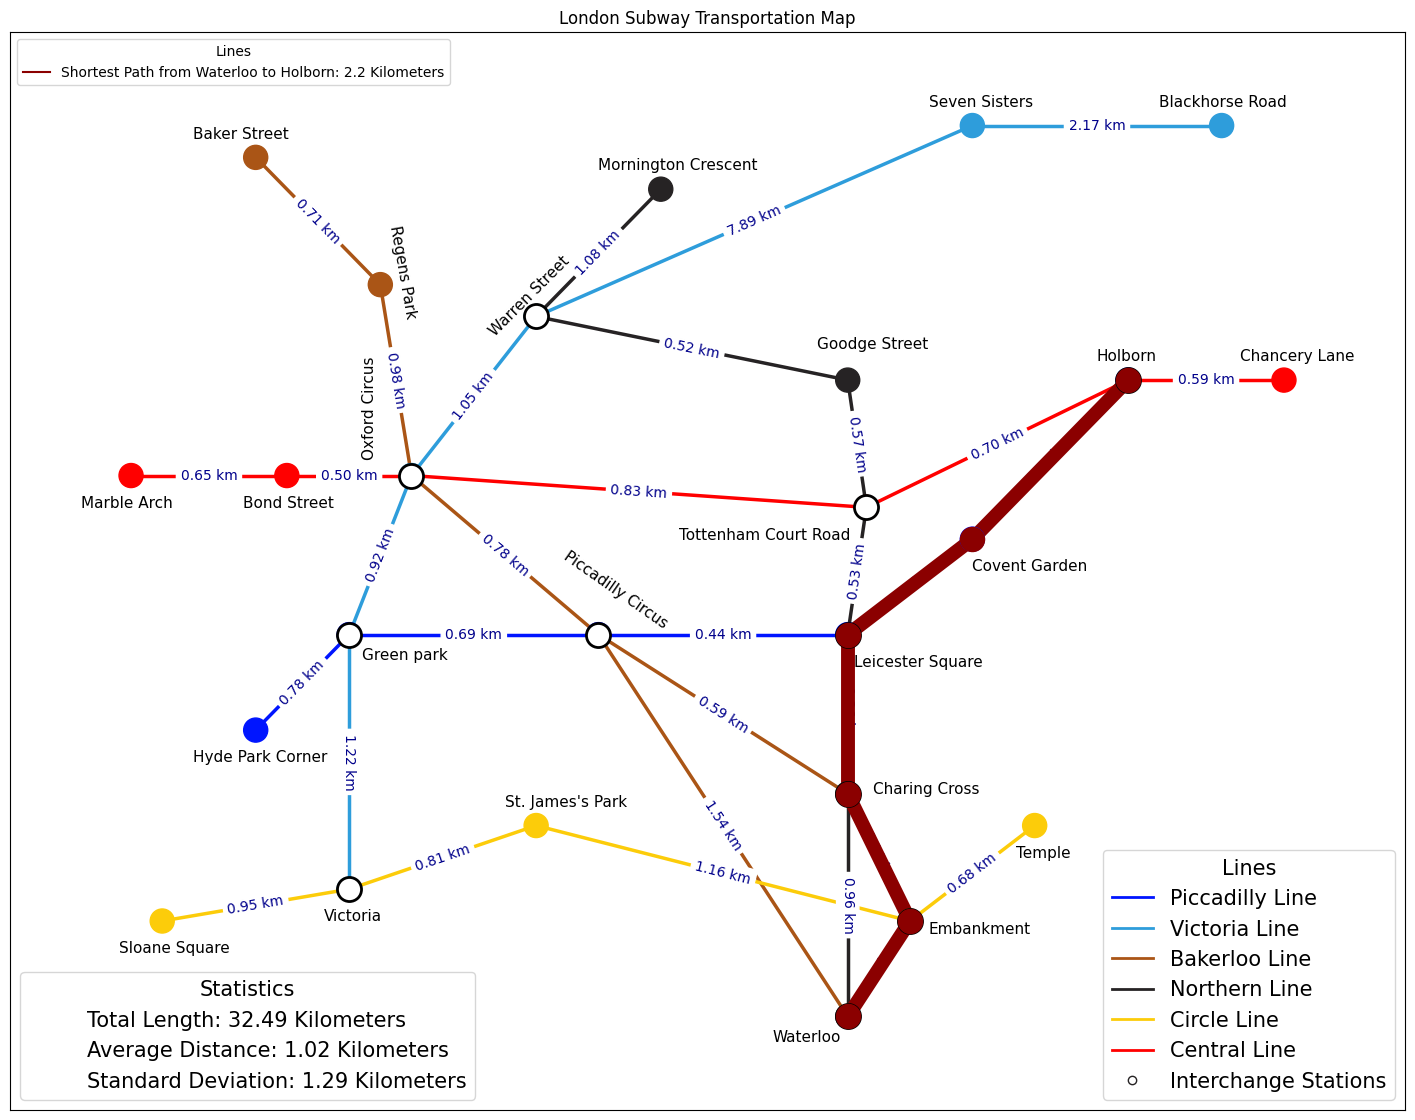

In [33]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd


def get_interchange_nodes(distance_df):
    interchange_node_dict = {}
    for index, row in distance_df.iterrows():
        if not row["StartStation"] in interchange_node_dict.keys():
            interchange_node_dict[row["StartStation"]] = 1
        else:
            interchange_node_dict[row["StartStation"]] += 1

        if not row["EndStation"] in interchange_node_dict.keys():
            interchange_node_dict[row["EndStation"]] = 1
        else:
            interchange_node_dict[row["EndStation"]] += 1

    interchange_nodes = []

    for key, val in interchange_node_dict.items():
        if interchange_node_dict[key] >= 3:
            interchange_nodes.append(key)

    return interchange_nodes


def draw_node_labels(edge_label_coords: list[dict], text_size: int = 11):
    for item in edge_label_coords:
        rotation = item.get("rotation", 0)
        plt.text(item["pos"]["x"], item["pos"]["y"], s=item["s"], size=text_size, rotation=rotation)


class MapGraph(nx.Graph):
    def add_node_to_graph(self, df):
        for index, row in df.iterrows():
            self.add_node(row["Station"], npos=(row["Latitude"], row["Longitude"]), ccn=row["Color"])
    
    def add_edge_to_graph(self, df):
        for index, row in df.iterrows():
            distance = row["Distance"]
            if row["Unit"] == "m":
                distance /= 1000
            self.add_edge(row["StartStation"], row["EndStation"], distance=f"{distance:.2f} km", cce=row["Color"], weight=round(distance,2))


col_names = ["Station", "Latitude", "Longitude", "Color"]
subway_df = pd.read_csv("subway_station_dataset.csv", usecols=col_names, na_values=["N/A", "Unknown"])
subway_df.dropna()
subway_df.drop_duplicates()

distance_df_colname = ["StartStation", "EndStation", "Distance", "Unit", "Color"]
distance_df = pd.read_csv("subway_station_distance.csv", usecols=distance_df_colname, na_values=["N/A", "Unknown"])
distance_df.dropna()
distance_df.drop_duplicates()

G = MapGraph()

G.add_node_to_graph(subway_df)
G.add_edge_to_graph(distance_df)

# Get positions from node attributes
pos = nx.get_node_attributes(G, 'npos')
node_colour = nx.get_node_attributes(G, 'ccn')
edge_colour = nx.get_edge_attributes(G, 'cce')

node_colours = list(node_colour.values())
edge_colours = list(edge_colour.values())

intersecting_nodes = get_interchange_nodes(distance_df=distance_df)

# Plotting
plt.figure(figsize=(18, 14))

# Draw Network
nx.draw_networkx(G, pos, node_color=node_colours, with_labels=False)

# Draw Nodes
nx.draw_networkx_nodes(G, pos, nodelist=intersecting_nodes, node_color='white', edgecolors='black', linewidths=2, node_size=300)

# Draw Edges
nx.draw_networkx_edges(G, pos, edge_color=edge_colours, width=2.5)

# Draw edge labels with distances
edge_labels = nx.get_edge_attributes(G, 'distance')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='darkblue')

text_size = 11
edge_label_coords = [
    # Piccadilly Label
    {"s": "Hyde Park Corner", "pos": {"x": 25, "y": 30}},
    {"s": "Green park", "pos": {"x": 52, "y": 46}},
    {"s": "Piccadilly Circus", "pos": {"x": 84, "y": 51}, "rotation": -35},
    {"s": "Leicester Square", "pos": {"x": 131, "y": 45}},
    {"s": "Covent Garden","pos": {"x": 150, "y": 60}},
    {"s": "Holborn", "pos": {"x": 170, "y": 93}},
    # Victoria Line Label
    {"s": "Victoria", "pos": {"x": 46, "y": 5}},
    {"s": "Oxford Circus", "pos": {"x": 52, "y": 78}, "rotation": 90},
    {"s": "Warren Street", "pos": {"x": 72, "y": 97}, "rotation": 45},
    {"s": "Seven Sisters", "pos": {"x": 143, "y": 133}},
    {"s": "Blackhorse Road", "pos": {"x": 180, "y": 133}},
    # Bakerloo Line Label
    {"s": "Embankment", "pos": {"x": 143, "y": 3}},
    {"s": "Charing Cross", "pos": {"x": 134, "y": 25}},
    {"s": "Regens Park", "pos": {"x": 56, "y": 100}, "rotation": 280},
    {"s": "Baker Street", "pos": {"x": 25, "y": 128}},
    # Northern Line Label
    {"s": "Waterloo", "pos": {"x": 118, "y": -14}},
    {"s": "Goodge Street", "pos": {"x": 125, "y": 95}},
    {"s": "Mornington Crescent", "pos": {"x": 90, "y": 123}},
    # Circle Line Label
    {"s": "St. James's Park", "pos": {"x": 75, "y": 23}},
    {"s": "Sloane Square", "pos": {"x": 13, "y": 0}},
    {"s": "Temple", "pos": {"x": 157, "y": 15}},
    # Central Line Label
    {"s": "Bond Street", "pos": {"x": 33, "y": 70}},
    {"s": "Marble Arch", "pos": {"x": 7, "y": 70}},
    {"s": "Tottenham Court Road", "pos": {"x": 103, "y": 65}},
    {"s": "Chancery Lane", "pos": {"x": 193, "y": 93}},
]

draw_node_labels(edge_label_coords, text_size=text_size)

total_length = round(G.size(weight="weight"), 2)
average_length = round(total_length / G.size(), 2)

weights = [d["weight"] for (u, v, d) in G.edges(data=True)]
std_distances = round(np.std(weights), 2)

print("This is the list of subway stations in London. You can choose your source and destination to find the shortest path.")
for station in subway_df["Station"]:
    print(f"{station}")

print("\n")

source = ""
target = ""

stations = list(subway_df["Station"])

while not source:
    source = input("Please type your source: ")
    source = source.strip().title()
    if source not in stations:
        print(f"{source} does not exist")
        source = ""
        continue

while not target:
    target = input("Please type your destination: ")
    target = target.strip().title()
    if target not in stations:
        print(f"{target} does not exist")
        target = ""
        continue


path = nx.shortest_path(G, source=source, target=target, weight='weight')
path_edges = list(zip(path, path[1:]))

shortet_path_length = round(nx.dijkstra_path_length(G, source, target), 2)

nx.draw_networkx_nodes(G,pos,nodelist=path, node_color='darkred')
nx.draw_networkx_edges(G,pos,edgelist=path_edges, edge_color='darkred', width=10)

# Add custom legend for the lines
line_labels = [
    Line2D([0], [0], color='#0015ff', lw=2, label='Piccadilly Line'),
    Line2D([0], [0], color='#2e9ddb', lw=2, label='Victoria Line'),
    Line2D([0], [0], color='#aa5516', lw=2, label='Bakerloo Line'),
    Line2D([0], [0], color='#262324', lw=2, label='Northern Line'),
    Line2D([0], [0], color='#fccc0a', lw=2, label='Circle Line'),
    Line2D([0], [0], color='#ff0000', lw=2, label='Central Line'),
    Line2D([0], [0], color='#262324', marker="o", lw=2, label='Interchange Stations', markerfacecolor="white", linestyle='None'),
]

line_labels_legend = plt.legend(handles=line_labels, loc='lower right', title="Lines", fontsize=15, title_fontsize=15)
shortest_path_labels = [Line2D([0], [0], color='darkred', label=f'Shortest Path from {source} to {target}: {shortet_path_length} Kilometers'),]
shortest_path_legend = plt.legend(handles=shortest_path_labels, loc='upper left', title="Lines", fontsize=10, title_fontsize=10)

# Add the first legend back to the plot
plt.gca().add_artist(line_labels_legend)
plt.gca().add_artist(shortest_path_legend)

stats_labels = [
    Line2D([0], [0], color='white', label=f'Total Length: {total_length:.2f} Kilometers'),
    Line2D([0], [0], color='white', label=f'Average Distance: {average_length:.2f} Kilometers'),
    Line2D([0], [0], color='white', label=f'Standard Deviation: {std_distances:.2f} Kilometers'),
]
stats_legend = plt.legend(handles=stats_labels, loc='lower left', title="Statistics", fontsize=15, title_fontsize=15)

# Display the title and remove axes
plt.title("London Subway Transportation Map")

#Save Graph to image
plt.savefig("task3.png")
plt.show()